In [1]:
from IPython import display
import os
import torch

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

В этом домашнем задании будем работать с [notMNIST](http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz). Датасет представляет из себя 10 классов - стандартные и не очень начертания букв от A до J. 

In [2]:
import pickle

with open('notMNIST_train.pickle', 'rb') as f:
    X_train = pickle.load(f)
    
with open('notMNIST_test.pickle', 'rb') as f:
    X_test = pickle.load(f)
    
with open('notMNIST_train_labels.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with open('notMNIST_test_labels.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [3]:
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

Посмотрим на данные. (Они уже отнормированы)

In [4]:
print('Max: {}, min: {}'.format(X_train.max(), X_train.min()))

Max: 0.5, min: -0.5


In [5]:
def plot_gallery(images, titles, n_row=3, n_col=6, cmap="gray"):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=cmap, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

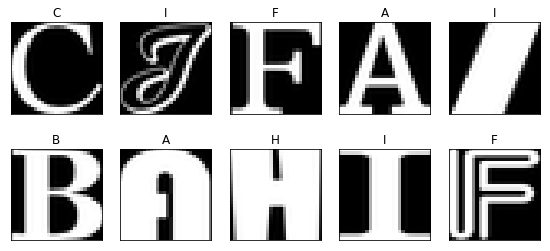

In [6]:
sample_ids = np.random.choice(X_train.shape[0], 10, replace=False)
plot_gallery(X_train[sample_ids], y_train[sample_ids], 2, 5)

Выполним OneHotEncoding, и превратим данные в Pytorch.tensor

In [7]:
oneHotEncoder = OneHotEncoder()
y_train_one_hot = oneHotEncoder.fit_transform(y_train_encoded.reshape(-1, 1)).toarray()
y_test_one_hot = oneHotEncoder.fit_transform(y_test_encoded.reshape(-1, 1)).toarray()

In [8]:
def to_tensor(X):
    return torch.from_numpy(X.astype('float32'))

In [9]:
X_train = to_tensor(X_train)
X_test = to_tensor(X_test)
y_train = to_tensor(y_train_one_hot)
y_test = to_tensor(y_test_one_hot)

Вернёмся к коду с семинара, воспользуемся им, чтобы обучить сеть

In [10]:
# from __future__ import print_function
from torch.autograd import Variable

Абстрактный слой. Два метода: forward - код, выполняющий прямой проход (реализуется для каждого слоя отдельно), backward - обратный проход, принимает optimizer, который делает всю грязную работу по обучению. Дополнительное поле - runtime для сохранения временных значений, необходимых в процессе обучения (например для момента градиента). Дополнительный метод visualize - вспомогательный, для вывода информации о слое.

In [11]:
class Layer(object):
    '''
        Абстрактный класс слоя
        
        input_shape - размер входного тензора, например (-1, 28, 28). 
        -1 означает, что размер по этой оси будет определяться в момент исполнения. 
        В данном случае -1 соответствует оси кол-ву элементов в батче (т.к. проход применяется ко всему батчу)
        
        output_shape - размер выходного тензора
    '''
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.params = []
        self.runtime = []
    '''
        Прямой проход
        
        input - входные данные размера self.input_shape
        
        test - флаг, указывающий на то, что сеть работает в режиме тестирования, а не обучения
    '''
    def forward(self, input, test=False):
        assert False, 'Abstract class'
    '''
        Обратный проход
        optimizer - объект с функцией update(params, output), обновляющий параметры
    '''
    def backward(self, optimizer):
        optimizer.update(self.params, self.runtime)
        
    def __repr__(self):
        assert False, 'Abstract class'

Полносвязный слой. Два переменных-параметра - weights и bias. (Делает преобразование вида $x W + b$, если вдруг кто-то смог забыть.)

In [12]:
class Dense(Layer):
    '''
        Полносвязный слой.
        
        input_size - кол-во фичей на входе
        output_size - кол-во фичей на выходе
    '''
    def __init__(self, input_size, output_size):
        assert input_size > 0
        assert output_size > 0
        super(Dense, self).__init__((-1, input_size), (-1, output_size))
        self.weights = Variable(torch.randn((input_size, output_size))/np.sqrt(input_size), requires_grad=True)
        self.bias = Variable(torch.randn(output_size)/np.sqrt(input_size), requires_grad=True)
        self.params = [self.weights, self.bias]
    
    def forward(self, x, test=False):
        self.output = x @ self.weights + self.bias
        return self.output
    
    def __repr__(self):
        return 'Dense Layer {} → {}'.format(self.input_shape, self.output_shape)

Слой, делающий нелинейное преобразование ReLU.

In [13]:
class ReLU(Layer):
    '''
        ReLU
    '''
    def __init__(self, input_shape):
        super(ReLU, self).__init__(input_shape, input_shape)
    
    def forward(self, x, test=False):
        self.output = x.clamp(min = 0)
        return self.output
    
    def __repr__(self):
        return 'Relu {}'.format(self.input_shape)

Слой, возвращающий *логарифм* преобразования Softmax ($softmax(x)_{i} = \frac{e^{x_i}}{\sum_{j}e^{x_j}}$) Мы берём логарифм, т.к. это вычисление более стабильно и имеет готовую реализацию.

In [14]:
class Softmax(Layer):
    '''
        Softmax 
    '''
    def __init__(self, input_size):
        super(Softmax, self).__init__((-1, input_size), (-1, input_size))
    
    def forward(self, x, test=False):
        self.output = torch.nn.functional.log_softmax(x)
        return self.output
    
    def __repr__(self):
        return 'Softmax {}'.format(self.input_shape)

 Слой, меняющий форму переданного тензора. Напоминание: .view() - преобразование формы тензора.

In [15]:
class Transform(Layer):
    '''
     Изменение формы
    '''
    def __init__(self, input_shape, output_shape):
        super(Transform, self).__init__(input_shape, output_shape)
        
    def forward(self, x, test=False):
        return x.view(self.output_shape)
    
    def __repr__(self):
        return 'Transform {} → {}'.format(self.input_shape, self.output_shape)

Абстрактная функция потерь. do_forward() - подсчёт функции потерь

In [16]:
class Loss(object):
    '''
        Абстрактная функция потерь
    '''
    def forward(self, x, y, params, test=False):
        self.output = self.do_forward(x, y, params, test)
        return self.output
    
    def backward(self):
        self.output.backward()
        
    def do_forward(self, x, y, params, test=False):
        assert False, 'Abstract class'
        
    def __repr__(self):
        assert False, 'Abstract class'
    

Кросс-энтропия $\sum_{l \in samples} \sum_{i \in classes} -y_{i}^{(l)}log(\hat{y_{i}}^{(l)})$. Т.к. softmax уже берёт логарифм, тут мы его не берём.

In [17]:
class CrossEntropy(Loss):
    '''
        Кросс-энтропия
    '''
    def do_forward(self, x, y, params, test=False):
        return torch.sum(-1 * y * torch.squeeze(x))
    
    def __repr__(self):
        return 'Cross entropy'

SeqNet - класс последовательной сети. 
- add() - добавить в конец новый слой
- setLoss() - установить функцию потерь
- forward() - последовательный прямой проход по добавленным слоям
- backward() - обратный проход и обновление параметров
- visualize() - вывод слоёв

In [18]:
class SeqNet:
    '''
        Сеть, связывающая слои последовательно
    '''
    def __init__(self):
        self.layers = []
        self.output = None
        self.loss = None
        self.params = []
        
    def add(self, layer):
        if len(self.layers) > 0:
            assert self.layers[-1].output_shape == layer.input_shape, \
                'Неправильный размер входа. Ожидался {}, но был получен {}'.format(self.layers[-1].output_shape, layer.input_shape)
        self.layers.append(layer)
        self.params.append(layer.params)
    
    def add_many(self, *layers):
        for l in layers:
            self.add(l)
    
    def setLoss(self, loss):
        self.loss = loss
        
    def forward(self, x, y=None, test=False):
        self.output = x
        for layer in self.layers:
            self.output = layer.forward(self.output, test)
        if (self.loss is not None) and (y is not None):
            self.loss_value = self.loss.forward(self.output, y, self.params, test)
        return self.output
    
    def backward(self, optimizer):
        self.loss.backward()
        for layer in self.layers[::-1]:
            layer.backward(optimizer)
            
    def __repr__(self):
        ans = "Sequential:\n    "
        ans += "\n    ".join(map(str, self.layers))
        if self.loss:
            ans += "\n    " + str(self.loss)
        return ans

Optimizer - ответственный за обновление весов. Получает на вход update() список параметров и список runtime-переменных.

In [19]:
class Optimizer:
    '''
         Абстрактный класс "оптимизатора"
    '''
    
    '''
         Вызывается после каждой эпохи
    '''
    def update_epoch(self, n):
        assert False, 'Abstract class'
    
    '''
        Обновление параметров
    '''
    def update(self, params, runtime):
        assert False, 'Abstract class'

In [20]:
class SimpleOptimizer(Optimizer):
    '''
        Простой "оптимизатор" с фиксированным learning rate
    '''
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def update_epoch(self, n):
        pass
        
    def update(self, params, runtime):
        for param in params:
            param.data -= self.learning_rate * param.grad.data

Функции для итерации батчей, обучения и подсчёта Accuracy

In [21]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
def accuracy(result, val_tensor):
    t, ind_result = torch.max(result, 1)
    t, ind_val = torch.max(val_tensor, 1)
    return (torch.sum((ind_result==ind_val).float())/len(val_tensor)).data.numpy()[0]

def train(net, optimizer, n_epochs, batch_size, X, y, X_test, y_test, shuffle=False):
    loss_history = []
    test_history = []
    x_tensor = Variable(torch.FloatTensor((batch_size, X.shape[1], X.shape[2])))
    test_tensor = Variable(X_test)
    val_tensor = Variable(y_test)
    y_tensor = Variable(torch.FloatTensor((batch_size, y.shape[1])))
    for i in range(n_epochs):
        loss_per_batch = []
        for x_batch, y_batch in iterate_minibatches(X, y, batch_size, shuffle):
            x_tensor.data=x_batch
            y_tensor.data=y_batch
            net.forward(x_tensor, y_tensor)
            loss_per_batch.append(net.loss_value.data.numpy()[0])
            net.backward(optimizer)
        optimizer.update_epoch(i)
        display.clear_output()
        result = net.forward(test_tensor, val_tensor, True)
        test_history.append(net.loss_value.data.numpy()[0]/len(X_test))
        print('Accuracy:{}'.format(accuracy(result, val_tensor)))
        loss_history.append(np.sum(loss_per_batch)/len(X))
        plt.plot(np.arange(i+1), loss_history, label='train')
        plt.plot(np.arange(i+1), test_history, label='test')
        plt.legend()
        plt.show()

Построим сеть:

In [22]:
net = SeqNet()
net.add(Transform((-1, 28, 28), (-1, 28*28)))
net.add(Dense(28*28, 320))
net.add(ReLU((-1, 320)))
net.add(Dense(320, 10))
net.add(Softmax(10))
net.setLoss(CrossEntropy())

print(net)

Sequential:
    Transform (-1, 28, 28) → (-1, 784)
    Dense Layer (-1, 784) → (-1, 320)
    Relu (-1, 320)
    Dense Layer (-1, 320) → (-1, 10)
    Softmax (-1, 10)
    Cross entropy


Accuracy:0.8726767897605896


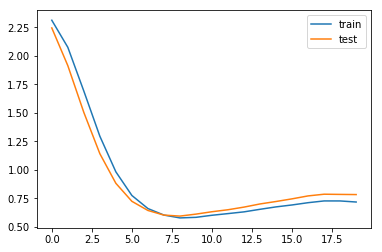

In [23]:
optimizer = SimpleOptimizer(1e-7)
train(net, optimizer, 20, 128, X_train, y_train, X_test, y_test)

Кажется, модель переобучается. Попробуем это исправить

### Задание 1: Градиентный спуск (1 балл)

Изменим градиентный спуск - добавим момент

$v_t = \beta v_{t-1} + \text{learning_rate} * \nabla_w J $  
$w_t = w_{t-1} - v_t$

In [24]:
class Moment:
    '''
        Класс, хранящийся в списке runtime в слое. 
        Если список пуст, а параметры у слоя есть, то инициализируются в init_runtime()
    '''
    def __init__(self, shape):
        self.moment = torch.FloatTensor(torch.from_numpy(np.zeros(shape, dtype='float32')))
    
    def __repr__(self):
        return "Moment"

class MomentOptimizer(Optimizer):
    def __init__(self, learning_rate, beta):
        self.learning_rate = learning_rate
        self.beta = beta
    
    def update_epoch(self, n):
        pass
    
    def update(self, params, runtime):
        # THE ERROR IS SOMEWHERE HERE
#         print("Optimizing…")
        if len(runtime) == 0 and len(params) > 0:
#             print("Adding runtime")
            self.init_runtime(params, runtime)
        for i in range(len(runtime)):
#             print("for i =", i)
#             print("i:", params[i].grad)
#             print("[i]:", dir(params[i].grad))
#             print()
            runtime[i].moment = self.beta * runtime[i].moment + self.learning_rate * params[i].grad.data
            params[i].data -= runtime[i].moment
            
    def init_runtime(self, params, runtime):
        for param in params:
            runtime.append(Moment(tuple(param.data.shape)))

In [25]:
net = SeqNet()
net.add(Transform((-1, 28, 28), (-1, 28*28)))
net.add(Dense(28*28, 320))
net.add(ReLU((-1, 320)))
net.add(Dense(320, 10))
net.add(Softmax(10))
net.setLoss(CrossEntropy())

net

Sequential:
    Transform (-1, 28, 28) → (-1, 784)
    Dense Layer (-1, 784) → (-1, 320)
    Relu (-1, 320)
    Dense Layer (-1, 320) → (-1, 10)
    Softmax (-1, 10)
    Cross entropy

Accuracy:0.8731040358543396


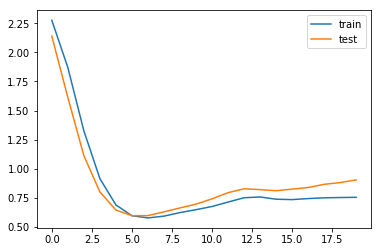

In [26]:
optimizer = MomentOptimizer(1e-7, 0.5)
train(net, optimizer, 20, 128, X_train, y_train, X_test, y_test)

Всё ещё сильное переобучение.

### Задание 2: Регуляризация  (1 балл)

Добавим L2-регуляризацию - сумму квадратов параметров по всем слоям. Также надо не забыть, что вычисления ведутся по батчу, а значит надо штрафовать пропорционально размеру батча

In [27]:
class CrossEntropyL2(Loss):
    '''
        Кросс-энтропия c L2 регуляризацией
    '''
    def __init__(self, l2_coeff):
        self.l2_coeff = l2_coeff
    
    def do_forward(self, x, y, params, test=False):
        params_sum = 0
        for layer_params in params:
            for param in layer_params:
                params_sum += torch.sum(param.data ** 2)
        return torch.sum(-1 * y * torch.squeeze(x)) + params_sum * self.l2_coeff
    
    def __repr__(self):
        return 'Cross entropy with L2'

In [28]:
net = SeqNet()
net.add(Transform((-1, 28, 28), (-1, 28*28)))
net.add(Dense(28*28, 320))
net.add(ReLU((-1, 320)))
net.add(Dense(320, 10))
net.add(Softmax(10))
net.setLoss(CrossEntropy())

net

Sequential:
    Transform (-1, 28, 28) → (-1, 784)
    Dense Layer (-1, 784) → (-1, 320)
    Relu (-1, 320)
    Dense Layer (-1, 320) → (-1, 10)
    Softmax (-1, 10)
    Cross entropy

Accuracy:0.8551591634750366


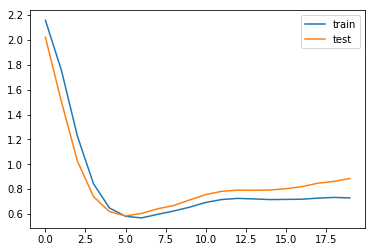

In [29]:
optimizer = MomentOptimizer(1e-7, 0.5)
train(net, optimizer, 20, 128, X_train, y_train, X_test, y_test)

### Задание 3: Свёрточные сети (2 балла)

Создадим свёрточный слой и max pooling слой. Мы могли бы их честно реализовать с помощью операций на тензорах, но их производительность была бы крайне низкой. Так что воспользуемся готовыми функциями torch.nn.functional.conv2d и torch.nn.functional.max_pool2d

In [30]:
class Conv(Layer):
    def __init__(self, input_width, input_height, input_depth, kernel_size, n_filters, stride=1, padding=0):
        super(Conv, self).__init__((-1, input_depth, input_width, input_height),
                                   (-1, n_filters, (input_width+2*padding-kernel_size+1)//stride,
                                                   (input_height+2*padding-kernel_size+1)//stride))
        self.n_filters = n_filters
        self.input_width = input_width
        self.input_height = input_height
        self.input_depth = input_depth
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.filters = Variable(
            torch.randn(
                self.n_filters,
                self.input_depth,
                self.kernel_size,
                self.kernel_size
            )
        )
#         torch.autograd.Variable(
#             torch.randn((n_filters, input_depth, kernel_size, kernel_size)) /\
#                 np.sqrt(n_filters * kernel_size * kernel_size)
#         )
        self.bias = torch.autograd.Variable(torch.from_numpy(np.zeros(n_filters, dtype='float32')))
        self.params = [self.filters, self.bias]
    
    def forward(self, x, test=False):
        print("filters:", self.filters.size())
        print("input:", x.size())
        self.output = torch.nn.functional.conv2d(
            x,
            self.filters,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding
        )
        print("output:", self.output.size())
        return self.output
    
    def __repr__(self):
        return 'Conv {}×{} ({}, {}, {}) → ({}, {}, {})'.format(
            self.kernel_size, self.kernel_size,
            self.input_depth, self.input_width, self.input_height,
            self.n_filters, self.output_shape[2], self.output_shape[3]
        )
        
class MaxPool(Layer):
    def __init__(self, input_width, input_height, input_depth, kernel_size):
        super(MaxPool, self).__init__((-1, input_depth, input_width, input_height),
                                   (-1, input_depth, input_width//kernel_size,
                                                   input_height//kernel_size))
        self.input_depth = input_depth
        self.input_width = input_width
        self.input_height = input_height
        self.kernel_size = kernel_size
    
    def forward(self, x, test=False):
        self.output = torch.nn.functional.max_pool2d(
            x,
            self.kernel_size
        )
        return self.output
    
    def __repr__(self):
        return 'Max Pool2d {} {} → {}'.format(self.kernel_size, self.input_shape, self.output_shape)

Следующая сеть просто проверяет корректность реализации и не даёт хорошего результата

In [31]:
net = SeqNet()
net.add_many(
    Transform((-1, 28, 28), (-1, 1, 28, 28)),
    Conv(28, 28, 1, 5, 10),
    ReLU((-1, 10, 24, 24)),
    MaxPool(24, 24, 10, 2),
    Conv(12, 12, 10, 5, 20),
    ReLU((-1, 20, 8, 8)),
    MaxPool(8, 8, 20, 2),
    Transform((-1, 20, 4, 4), (-1, 20*4*4)),
    Dense(20*4*4, 10),
    Softmax(10)
)
net.setLoss(CrossEntropyL2(0.0002))
net

Sequential:
    Transform (-1, 28, 28) → (-1, 1, 28, 28)
    Conv 5×5 (1, 28, 28) → (10, 24, 24)
    Relu (-1, 10, 24, 24)
    Max Pool2d 2 (-1, 10, 24, 24) → (-1, 10, 12, 12)
    Conv 5×5 (10, 12, 12) → (20, 8, 8)
    Relu (-1, 20, 8, 8)
    Max Pool2d 2 (-1, 20, 8, 8) → (-1, 20, 4, 4)
    Transform (-1, 20, 4, 4) → (-1, 320)
    Dense Layer (-1, 320) → (-1, 10)
    Softmax (-1, 10)
    Cross entropy with L2

In [32]:
optimizer = MomentOptimizer(1e-7, 0.4)
train(net, optimizer, 10, 128, X_train, y_train, X_test, y_test)

  0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':



filters: torch.Size([10, 1, 5, 5])
input: torch.Size([128, 1, 28, 28])
output: torch.Size([128, 10, 24, 24])
filters: torch.Size([20, 10, 5, 5])
input: torch.Size([128, 10, 12, 12])
output: torch.Size([128, 20, 8, 8])


AttributeError: 'NoneType' object has no attribute 'data'

### Задание 4: Собственная сеть (6 баллов)

А теперь настало время написать собственную сеть. За вдохновением можно обратиться к архитектурам подобным [LeNet 5](https://www.pyimagesearch.com/wp-content/uploads/2016/06/lenet_architecture.png).
Для этого надо воспользоваться всем инструментарием, который мы уже написали и реализовать хотя бы один дополнительный оптимизатор или слой.
#### Критерии:
1. Реализовано хотя бы одно из слеующего (2 балла):
    - Dropout
    - Adam (модификация градиентного спуска)
    - RMSProp (модификация градиентного спуска)
2. Получен Accuracy >=0.91 на тестовом сете (2 балла)
3. Получен Accuracy >=0.92.5 на тестовом сете (1 балл)
4. Получен Accuracy >=0.94 на тестовом сете (1 балл)

Обучение должно занимать меньше 10 минут на CPU (этого времени более, чем достаточно для получения требуемых результатов). При обучении данные тестового датасета не должны использоваться кроме как для замера качества.

Советы по реализации:
  - Не переусложняйте. Не надо пытаться сделать очень глубокую сеть - они слишком сложны для такой задачи и будут только переобучаться.
  - 50 (даже 30) эпох более, чем достаточно для достижения цели
  - Dropout наиболее эффективно работает перед полносвязными слоями
  - Если сеть совсем не обучается или значения функции потерь сильно скачут - скорее всего неверно подобран learning rate

#### На выбор:
##### Dropout
Dropout можно реализовать поэлементным перемножением входного тензора на тензор со сгенерированными нулями и единицами, полученными, например, с помощью *np.random.binomial(1, self.p, tuple(x.data.shape))*.  
Не забудьте, что dropout вне режима обучения просто домножает значения на ту вероятность, с которой пропускался сигнал в режиме обучения. Отличать режимы можно с помощью параметра *test* в *forward()*

##### Adam
Adam на t-й итерации вычисляется следующим образом:  
$m_t = \beta_1 m_{t−1}+(1−\beta_1)g_t$  
$v_t=\beta_2 v_{t−1}+(1−\beta_2)g_t^2$  
$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$  
$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$  
$w_t = w_{t-1} - \frac{\eta}{\sqrt{\hat{v}_t}+\epsilon} \hat{m}_t $

$\beta_1$, $\beta_2$ - гиперпараметры, обычно ~0.9 и ~0.999   
$g_t$ - градиент параметров на t-й итерации  
$w_t$ - параметры на t-й итерации  
$\eta$ - learning rate  
$\epsilon$ ~ $10^{-8}$ - для избежания деления на 0

##### RMSprop
RMSprop на t-й итерации вычисляется следующим образом:  
$v_t=\gamma v_{t−1}+(1−\gamma)g_t^2$  
$w_t = w_{t-1} - \frac{\eta}{\sqrt{v_t+\epsilon}} g_t $

$\gamma$ - гиперпараметр, обычно ~0.9
$g_t$ - градиент параметров на t-й итерации  
$w_t$ - параметры на t-й итерации  
$\eta$ - learning rate  
$\epsilon$ ~ $10^{-8}$ - для избежания деления на 0

### Бонус - визуализация свёрточной сети

Картинки, дающие максимальный отклик фильтров. Получим их с помощью магии autograd, взяв градиент по входной картинке.

In [ ]:
def maximize(filter_id, net, layer_id):
    input = Variable(torch.randn((1, 28,28)), requires_grad = True)
    optimizer = MomentOptimizer(3, 0.5)
    runtime = []
    params = [input]
    for i in range(5000):
        net.forward(input)
        f = -torch.sum(net.layers[layer_id].output[:, filter_id, :, :])
        f.backward()
        optimizer.update(params, runtime)
    plt.imshow(input.data.numpy()[0], cmap='gray')
    plt.show()
    
first_level = # Номер слоя, вывод которого максимизируем.
first_level_filters =  # Количество фильтров на слое
second_level =  # Номер слоя, вывод которого максимизируем.
second_level_filters = # Количество фильтров на слое

Первый свёрточный слой (после нелинейности). Как видно фильтры этого слоя выделяют штрихи в разных направлениях

In [ ]:
for i in range(first_level_filters):
    maximize(i, net, first_level)

Второй свёрточный слой (после нелинейности). Фильтры выделяют более сложные паттерны.

In [ ]:
for i in range(second_level_filters):
    maximize(i, net, second_level)

Посмотрим, как выглядят карты признаков для случайной буквы из датасета.

In [ ]:
'''
    Карты признаков
'''
def visualize_feature_maps(net, sample):
    net.forward(Variable(sample), test=True)
    fig, axes = plt.subplots(2, first_level_filters, figsize=(20, 5))
    for i in range(first_level_filters):
        axes[0, i].imshow(net.layers[1].output.data.numpy()[0, i, :, :], cmap='gray')
        axes[1, i].imshow(net.layers[3].output.data.numpy()[0, i, :, :], cmap='gray')
    fig, axes = plt.subplots(2, second_level_filters, figsize=(20, 5))
    for i in range(second_level_filters):
        axes[0, i].imshow(net.layers[4].output.data.numpy()[0, i, :, :], cmap='gray')
        axes[1, i].imshow(net.layers[6].output.data.numpy()[0, i, :, :], cmap='gray')
    plt.show()


In [ ]:
sample_id = np.random.randint(0, len(y_train))
sample = X_train[sample_id:sample_id+1]
plt.imshow(sample[0].numpy(), cmap='gray')
plt.show()

visualize_feature_maps(net, sample)

# Визуализация последнего полносвязного слоя
#plt.imshow(net.layers[#<номер слоя>].output.data.view(1, 10).numpy(), cmap='gray')
#plt.show()